In [ ]:
# forecasts look incorrect (at bottom)
# how is confidence interval working?

# why does range(0,3) take so much longer than range(0,2)? 
# example had larger range - any way to speed it up?

# what's the relationship between differencing and pdq?
# if we're looking at a 1 unit difference, should d be 1?

# most of the pdq values are the same - is that coincidence?
# is it because the "shape" of the data is similar?

# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
#for math and data structure
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error


#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import itertools

# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose as sd

#for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('zillow_data.csv')
display(df.head())
df.info()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Step 2: Data Preprocessing

In [3]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [4]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [5]:
# I'll look at the area I grew up in, since I know it well

dtw = df[(df.Metro == 'Detroit')].copy()
dtw.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
121,79040,48180,Taylor,MI,Detroit,Wayne,122,69000.0,69500.0,69800.0,...,87700,88500,88900,89200,90300,91700,93000,94000,95100,96200
238,79044,48185,Westland,MI,Detroit,Wayne,239,94800.0,95500.0,96300.0,...,132900,135000,136600,137400,138200,139200,140100,140900,141700,142400
579,78942,48066,Roseville,MI,Detroit,Macomb,580,76700.0,77100.0,77500.0,...,84200,85800,87500,88400,89400,90600,91600,92400,93300,94000
659,79046,48187,Canton,MI,Detroit,Wayne,660,153700.0,154500.0,155400.0,...,245400,247700,249800,250400,251100,252000,253400,255200,257200,258200
761,78926,48044,Macomb,MI,Detroit,Macomb,762,167400.0,168800.0,170200.0,...,283500,285100,286100,286100,286400,286700,287400,289700,292700,293800


In [6]:
dtw.RegionName.unique()

array([48180, 48185, 48066, 48187, 48044, 48307, 48183, 48170, 48111,
       48843, 48073, 48060, 48188, 48146, 48047, 48310, 48154, 48239,
       48127, 48186, 48124, 48195, 48312, 48313, 48178, 48021, 48071,
       48152, 48174, 48237, 48236, 48067, 48322, 48446, 48091, 48089,
       48101, 48317, 48045, 48116, 48309, 48336, 48080, 48192, 48220,
       48328, 48150, 48042, 48135, 48076, 48335, 48316, 48390, 48167,
       48092, 48315, 48340, 48093, 48329, 48326, 48075, 48306, 48009,
       48327, 48083, 48346, 48088, 48371, 48134, 48081, 48085, 48348,
       48331, 48168, 48314, 48382, 48033, 48169, 48442, 48393, 48114,
       48334, 48094, 48184, 48240, 48034, 48082, 48386, 48098, 48230,
       48072, 48084, 48043, 48304, 48059, 48193, 48323, 48302, 48051,
       48324, 48026, 48025, 48362, 48855, 48381, 48017, 48001, 48374,
       48301, 48836, 48173, 48079, 48462, 48383, 48138, 48040, 48360,
       48065, 48015, 48062, 48074, 48359, 48164, 48357, 48039, 48165,
       48356, 48455,

In [7]:
# making sure we don't have any null values
dtw.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
             ..
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 272, dtype: int64

In [8]:
# let's name a duplicate dataframe that we can manipulate, without changing dtw
dtw_values = dtw.copy()
dtw_values.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
121,79040,48180,Taylor,MI,Detroit,Wayne,122,69000.0,69500.0,69800.0,...,87700,88500,88900,89200,90300,91700,93000,94000,95100,96200
238,79044,48185,Westland,MI,Detroit,Wayne,239,94800.0,95500.0,96300.0,...,132900,135000,136600,137400,138200,139200,140100,140900,141700,142400
579,78942,48066,Roseville,MI,Detroit,Macomb,580,76700.0,77100.0,77500.0,...,84200,85800,87500,88400,89400,90600,91600,92400,93300,94000
659,79046,48187,Canton,MI,Detroit,Wayne,660,153700.0,154500.0,155400.0,...,245400,247700,249800,250400,251100,252000,253400,255200,257200,258200
761,78926,48044,Macomb,MI,Detroit,Macomb,762,167400.0,168800.0,170200.0,...,283500,285100,286100,286100,286400,286700,287400,289700,292700,293800


In [9]:
#Calculate historical return on investment
dtw_values['ROI']= (dtw_values['2018-04']/dtw_values['1996-04'])-1

#Calculate standard deviation of monthly values
dtw_values['std'] = dtw_values.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
dtw_values['mean'] = dtw_values.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
dtw_values['CV'] = dtw_values['std']/dtw_values['mean']

#Show calculated values
dtw_values[['RegionName','std','mean','ROI','CV']].head()

,RegionName,std,mean,ROI,CV
121,48180,25067.365116,87196.981132,0.394203,0.287480
238,48185,28086.542816,119930.943396,0.502110,0.234189
579,48066,28348.051009,88183.396226,0.225554,0.321467
659,48187,31496.847488,198468.679245,0.679896,0.158699
761,48044,33143.826926,219894.339623,0.755078,0.150726


In [10]:
#Descriptive statistics of coefficients of variance.
print(dtw_values.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = dtw_values.CV.quantile(.75)
print(f'\nCV upper limit: {upper_cv}')

count    153.000000
mean       0.200030
std        0.057830
min        0.098473
25%        0.164872
50%        0.179374
75%        0.210413
max        0.418933
Name: CV, dtype: float64

CV upper limit: 0.2104128930959207


In [11]:
#Get the 5 zipcodes with highest ROIs within the firms risk profile.
dtw_best5 = dtw_values[dtw_values['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]

print('\n Best 5 Zipcodes:')
dtw_best5[['RegionName','ROI','CV']]


 Best 5 Zipcodes:


,RegionName,ROI,CV
12064,48063,1.600760,0.205330
10974,48137,1.389269,0.182321
11778,48367,1.349120,0.185515
9112,48357,1.321582,0.188418
7818,48383,1.304888,0.190339


In [12]:
#Get Location Names
best5_zipcodes = list(dtw_best5.RegionName.values)
for i in best5_zipcodes:
    city = dtw[dtw['RegionName']==i].City.values[0]
    state = dtw[dtw['RegionName']==i].State.values[0]
    print(f'Zipcode : {i} \nLocation: {city}, {state}\n')

Zipcode : 48063 
Location: Columbus, MI

Zipcode : 48137 
Location: Gregory, MI

Zipcode : 48367 
Location: Leonard, MI

Zipcode : 48357 
Location: Highland, MI

Zipcode : 48383 
Location: White Lake, MI



# Time Series Analysis

In [13]:
dtw_values.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI,std,mean,CV
121,79040,48180,Taylor,MI,Detroit,Wayne,122,69000.0,69500.0,69800.0,...,90300,91700,93000,94000,95100,96200,0.394203,25067.365116,87196.981132,0.287480
238,79044,48185,Westland,MI,Detroit,Wayne,239,94800.0,95500.0,96300.0,...,138200,139200,140100,140900,141700,142400,0.502110,28086.542816,119930.943396,0.234189
579,78942,48066,Roseville,MI,Detroit,Macomb,580,76700.0,77100.0,77500.0,...,89400,90600,91600,92400,93300,94000,0.225554,28348.051009,88183.396226,0.321467
659,79046,48187,Canton,MI,Detroit,Wayne,660,153700.0,154500.0,155400.0,...,251100,252000,253400,255200,257200,258200,0.679896,31496.847488,198468.679245,0.158699
761,78926,48044,Macomb,MI,Detroit,Macomb,762,167400.0,168800.0,170200.0,...,286400,286700,287400,289700,292700,293800,0.755078,33143.826926,219894.339623,0.150726


In [14]:
# we can remove these calculations now that we've determined the top five
dtw_values = dtw_values.drop(['std','mean','ROI','CV'],axis=1)

In [15]:
# reshape from wide to long format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro',
                                'CountyName', 'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], infer_datetime_format=True)
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [16]:
dtw_melted = melt_data(dtw)
dtw_melted.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,79040,48180,Taylor,MI,Detroit,Wayne,122,1996-04-01,69000.0
1,79044,48185,Westland,MI,Detroit,Wayne,239,1996-04-01,94800.0
2,78942,48066,Roseville,MI,Detroit,Macomb,580,1996-04-01,76700.0
3,79046,48187,Canton,MI,Detroit,Wayne,660,1996-04-01,153700.0
4,78926,48044,Macomb,MI,Detroit,Macomb,762,1996-04-01,167400.0


In [17]:
list5 = dtw_best5.RegionName.unique()
print(list5)

[48063 48137 48367 48357 48383]


In [18]:
best5_melted = dtw_melted[(dtw_melted.RegionName.isin(list5))]
best5_melted.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
113,79174,48383,White Lake,MI,Detroit,Oakland,7819,1996-04-01,120700.0
123,79157,48357,Highland,MI,Detroit,Oakland,9113,1996-04-01,116300.0
140,79006,48137,Gregory,MI,Detroit,Livingston,10975,1996-04-01,87600.0
146,79164,48367,Leonard,MI,Detroit,Oakland,11779,1996-04-01,147800.0
148,78939,48063,Columbus,MI,Detroit,Saint Clair,12065,1996-04-01,78900.0


In [19]:
best5_melted = best5_melted.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
best5_melted.head()

,RegionName,Month,MeanValue
113,48383,1996-04-01,120700.0
123,48357,1996-04-01,116300.0
140,48137,1996-04-01,87600.0
146,48367,1996-04-01,147800.0
148,48063,1996-04-01,78900.0


In [20]:
# let's make sure our time is the axis
best5_melted = best5_melted.set_index('Month')
best5_melted.head()

,RegionName,MeanValue
Month,,
1996-04-01,48383,120700.0
1996-04-01,48357,116300.0
1996-04-01,48137,87600.0
1996-04-01,48367,147800.0
1996-04-01,48063,78900.0


In [21]:
# Looks great! Let's move on

#Create individualized time series for each zipcode.
#List containing the 5 different time series.
dfs_ts = []
for zc in list5:
    #Create separate dataframes for each zipcode with a monthly frequency.
    df = best5_melted[best5_melted['RegionName']==zc].asfreq('MS')
    dfs_ts.append(df)
print('\nZipcode 48063 time series:')
dfs_ts[0].head()


Zipcode 48063 time series:


,RegionName,MeanValue
Month,,
1996-04-01,48063,78900.0
1996-05-01,48063,81000.0
1996-06-01,48063,83100.0
1996-07-01,48063,85300.0
1996-08-01,48063,87400.0


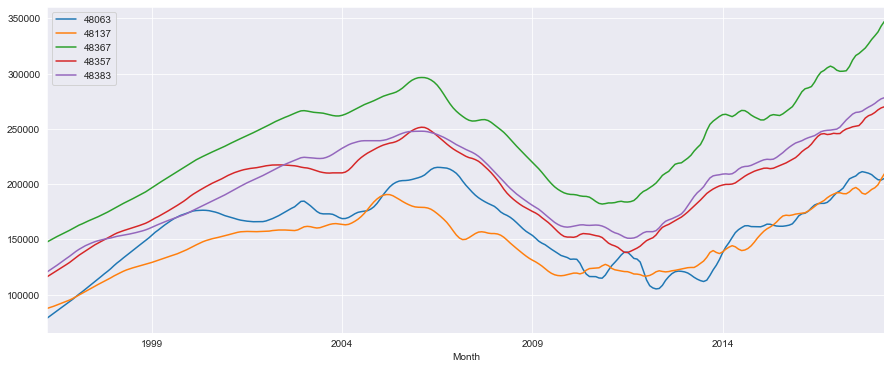

In [22]:
for i in range(5):
    dfs_ts[i].MeanValue.plot(label=dfs_ts[i].RegionName[0],figsize=(15,6))
    plt.legend()

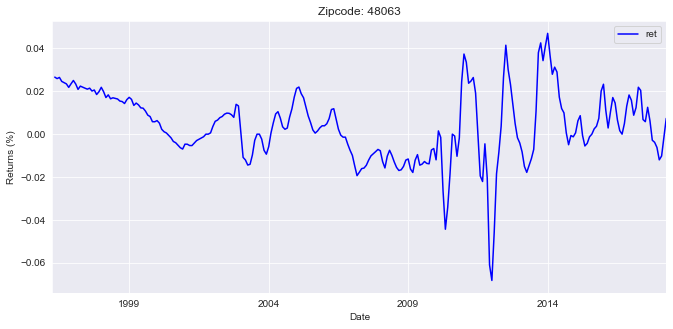

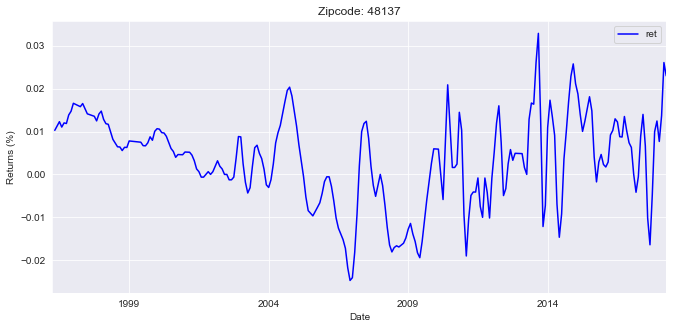

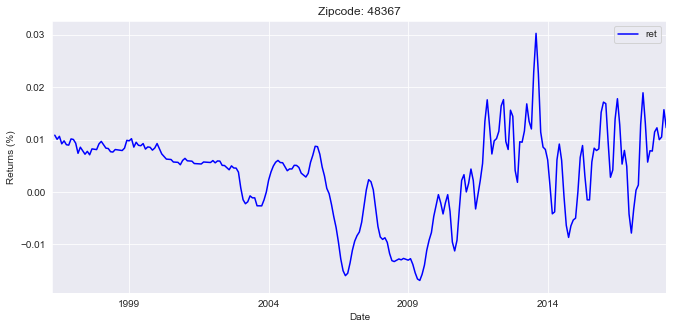

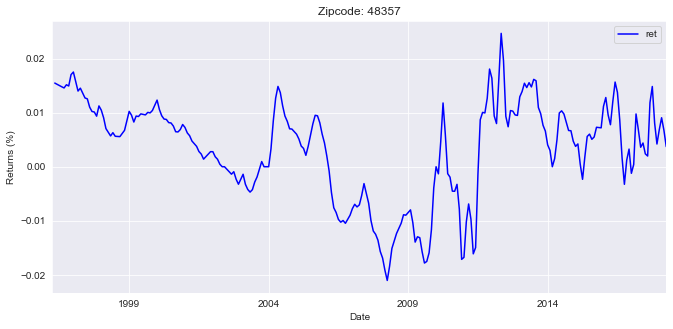

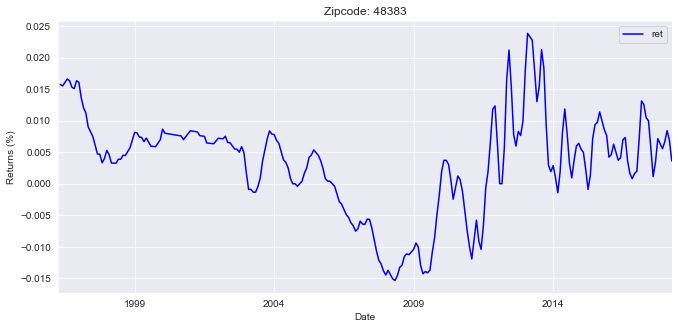

In [23]:
# Next, we'll calculate the monthly returns
# This is the date we'll use for our model
# We're ultimately looking for stationarity here - so let's work towards that!

#Calculate monthly returns in new column 'ret' for each zipcode.
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['ret']=np.nan*len(dfs_ts[zc])
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['ret'][i+1]= (dfs_ts[zc].MeanValue.iloc[i+1] / dfs_ts[zc].MeanValue.iloc[i]) - 1
        
#Plot the monthly returns of each zipcode
for i in range(len(dfs_ts)):
    dfs_ts[i].ret.plot(figsize=(11,5), color = 'b')
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()
    


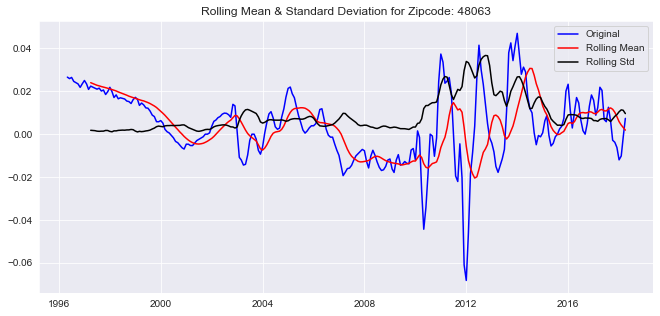

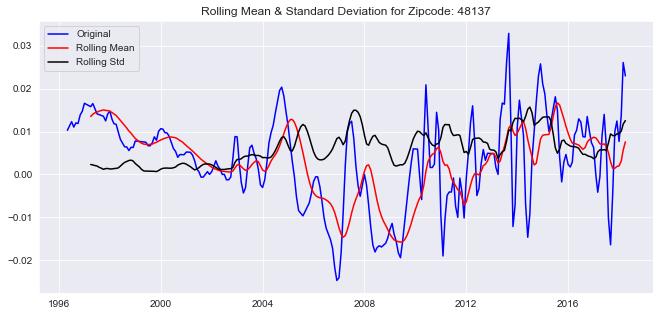

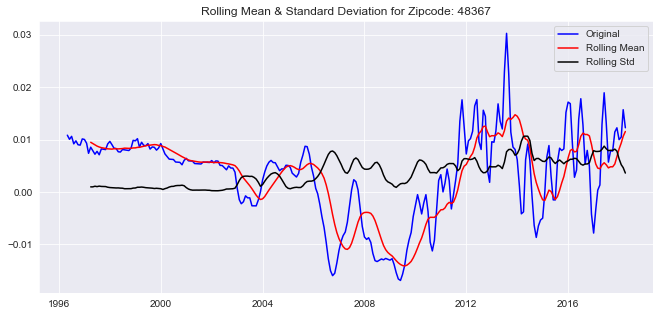

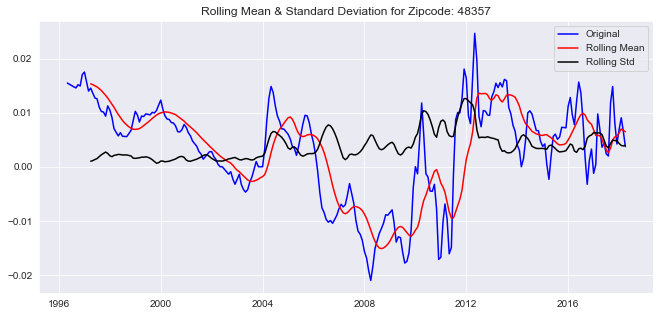

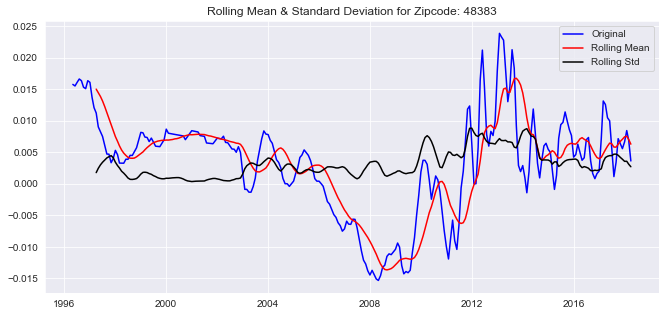

In [24]:
#Plot each of the zipcodes' returns with their respective rolling mean and rolling standard deviation.
#Visually test for stationarity.

for i in range(len(dfs_ts)):
    rolmean = dfs_ts[i].ret.rolling(window = 12, center = False).mean()
    rolstd = dfs_ts[i].ret.rolling(window = 12, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(dfs_ts[i].ret, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

In [26]:
for i in range(5):
    results = adfuller(dfs_ts[i].ret.dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 48063
p-value: 0.1324243170684163
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 48137
p-value: 0.19048898221110383
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 48367
p-value: 0.3578931400395823
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 48357
p-value: 0.3392036332377075
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 48383
p-value: 0.27445271525166703
Fail to reject the null hypothesis. Data is not stationary.



In [27]:
# Our first try wasn't stationary - let's see what happens when we use the first difference

for i in range(5):
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(dfs_ts[i].ret.diff().dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 48063
p-value: 2.0221097876627712e-16
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 48137
p-value: 1.6669958747152777e-08
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 48367
p-value: 1.142791370218974e-06
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 48357
p-value: 4.301767926372633e-11
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 48383
p-value: 3.242729053615567e-09
Reject the null hypothesis. Data is stationary.



In [28]:
dfs_ts[0].head()

,RegionName,MeanValue,ret
Month,,,
1996-04-01,48063,78900.0,NaN
1996-05-01,48063,81000.0,0.026616
1996-06-01,48063,83100.0,0.025926
1996-07-01,48063,85300.0,0.026474
1996-08-01,48063,87400.0,0.024619


In [29]:
# Instantiate individual time series for each of the zipcodes.
# We're doing this so we can use them in the function below

TS_48063 = dfs_ts[0].MeanValue

# TS_48063 = dfs_ts[0].ret.dropna()#Zipcode 70808 monthly returns time series
# TS_48063 = dfs_ts[0].ret.diff().dropna()#Zipcode 29461 monthly returns differenced time series

# TS_48137 = dfs_ts[1].ret.dropna()#Zipcode 29461 monthly returns time series
# TS_48137 = dfs_ts[1].ret.diff().dropna()#Zipcode 29461 monthly returns differenced time series

# TS_48367 = dfs_ts[2].ret.dropna()#Zipcode 3820 monthly returns time series
# TS_48367 = dfs_ts[2].ret.diff().dropna()#Zipcode 3820 monthly returns differenced time series

# TS_48357 = dfs_ts[3].ret.dropna()#Zipcode 52722 monthly returns time series
# TS_48357 = dfs_ts[3].ret.diff().dropna()#Zipcode 29461 monthly returns differenced time series

# TS_48383 = dfs_ts[4].ret.dropna()#Zipcode 70809 monthly returns time series
# TS_48383 = dfs_ts[4].ret.diff().dropna()#Zipcode 70809 monthly returns differenced time series

# Zipcode  #1 - 48063

In [30]:
#p_values = [0, 1, 2, 4, 6, 8, 10]
#d_values = range(0, 3)
#q_values = range(0, 3)

# Define the p, d and q parameters 
p = d= q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:    
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_48063,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           3937.86
Name: 63, dtype: object

In [32]:
def train_test(df):
    #Set training data before 2016
    train = df[:'2015-04']
    #Set test data starting 2016
    test = df['2015-05':]
    return train, test

def model_fit(df,pdq=(1,1,1),pdqs=(1,1,1,12)):
    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results

                                     SARIMAX Results                                      
Dep. Variable:                          MeanValue   No. Observations:                  229
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1982.228
Date:                            Wed, 15 Apr 2020   AIC                           3974.456
Time:                                    19:13:03   BIC                           3991.333
Sample:                                04-01-1996   HQIC                          3981.274
                                     - 04-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7045      0.047     14.916      0.000       0.612       0.797
ma.L1         -0.4286      0.048   

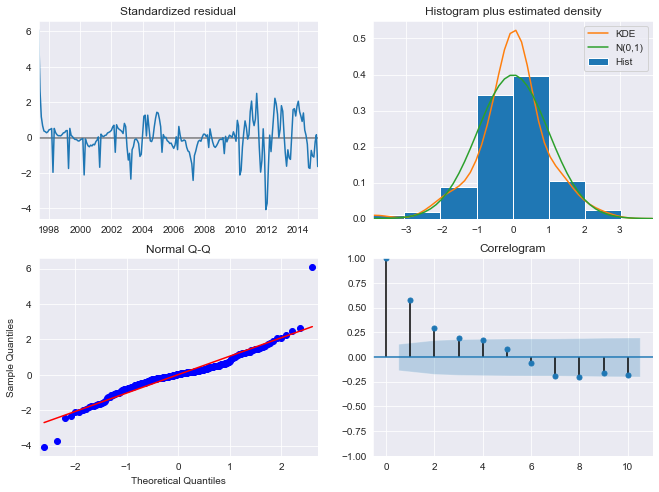

In [33]:
#Fit the SARIMA model and get results.
pdq = (1,1,1)
pdqs = (1,1,1,12)
train, test, results = model_fit(TS_48063,pdq=pdq,pdqs=pdqs)

In [69]:
forecast[2]

166442.46693981584

In [71]:
forecast_conf_int

166442.46693981584

In [66]:
forecast = results.forecast(36)

In [67]:
# how can this as well as the cell below work?
actual_forecast = forecast[0]
forecast_conf_int = forecast[2]

In [68]:
# make dataframe with forecast and 95% confidence interval 
df_forecast = pd.DataFrame({'time': pd.date_range(start = '2018-05-01', end = '2020-04-01', freq = 'MS')})
df_forecast['forecast'] = actual_foreacst
df_forecast['lower_bound'] = forecast_conf_int[:, 0]
df_forecast['upper_bound'] = forecast_conf_int[:, 1]
df_forecast.set_index('time', inplace = True)

IndexError: invalid index to scalar variable.

# Zipcode #2 - 48137

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:    
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_48137,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
#Fit the SARIMA model and get results.
pdq = (0,0,1)
pdqs = (0,0,0,12)
train, test, results = model_fit(TS_48137,pdq=pdq,pdqs=pdqs)

In [ ]:
forecast(TS_48137, '2014-01-01', '2012-04-01')

# Zipcode #3 - 48367

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:    
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_48367,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
#Fit the SARIMA model and get results.
pdq = (0,0,1)
pdqs = (0,0,0,12)
train, test, results = model_fit(TS_48367,pdq=pdq,pdqs=pdqs)

In [ ]:
forecast(TS_48367, '2014-01-01', '2012-04-01')

# Zipcode #4 - 48357

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:    
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_48357,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
#Fit the SARIMA model and get results.
pdq = (0,0,1)
pdqs = (0,0,0,12)
train, test, results = model_fit(TS_48357,pdq=pdq,pdqs=pdqs)

In [ ]:
forecast(TS_48357, '2014-01-01', '2012-04-01')

# Zipcode #5 - 48383

In [ ]:
#p_values = [0, 1, 2, 4, 6, 8, 10]
#d_values = range(0, 3)
#q_values = range(0, 3)


# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0,2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
ans = []
for comb in pdq:    
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(TS_48383,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
#Fit the SARIMA model and get results.
pdq = (1,0,1)
pdqs = (0,0,0,12)
train, test, results = model_fit(TS_48383,pdq=pdq,pdqs=pdqs)

In [ ]:
forecast(TS_48383, '2014-01-01', '2012-04-01')

# Analyzing our Forecasts 

## Zipcode #1 - 48063

In [ ]:
dtw_values.head()

In [ ]:
data_48063 = dtw_values[dtw_values.RegionName == 48063]
data_48063.head()

In [ ]:
melted_48063 = melt_data(data_48063)
melted_48063.head()

In [ ]:
#melted_48063 = melted_48063.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],axis=1)
#melted_48063 = melted_48063.set_index('Month')
melted_48063.tail()

In [ ]:
# make forecast 
model = ARIMA(melted_48063, order=(0,0,1))
model_fit = model.fit(disp=0)

In [ ]:
forecast = model_fit.forecast(24)

In [ ]:
actual_foreacst = forecast[0]
forecast_conf_int = forecast[2]

In [ ]:
# make dataframe with forecast and 95% confidence interval 
df_forecast = pd.DataFrame({'time': pd.date_range(start = '2018-05-01', end = '2020-04-01', freq = 'MS')})
df_forecast['forecast'] = actual_foreacst
df_forecast['lower_bound'] = forecast_conf_int[:, 0]
df_forecast['upper_bound'] = forecast_conf_int[:, 1]
df_forecast.set_index('time', inplace = True)

In [ ]:
# combine raw data dataframe and forecast dataframe
df_new = pd.concat([melted_48063, df_forecast])

In [ ]:
df_new.head()

In [ ]:
fig = plt.figure(figsize = (12, 8))

plt.plot(df_new['MeanValue'], label = 'raw data')
plt.plot(df_new['forecast'], label = 'forecast')
plt.fill_between(df_new.index, df_new['lower_bound'], df_new['upper_bound'], color="k", alpha=.15,
                label = 'confidence interval')
plt.legend(loc = 'upper left')
plt.title('Forecast for 48063')

In [ ]:
# forecasted price after 2 years
forcast_2_years = df_new.loc['2020-04-01', 'forecast']
forcast_lower = df_new.loc['2020-04-01', 'lower_bound']
forcast_upper = df_new.loc['2020-04-01', 'upper_bound']

In [ ]:
last_price = melted_48063.loc['2018-04-01', 'MeanValue']

In [ ]:
predicted_percent_change = (forcast_2_years - last_price) / last_price
print(f' I would expect a  {np.round(predicted_percent_change * 100, 4)}% return on my investment in 48063')

In [ ]:
best_percent_change = (forcast_upper - last_price) / last_price
print(f'Best case scenario I would expect a  {np.round(best_percent_change * 100, 4)}% return on my investment in 48063')


worst_percent_change = (forcast_lower - last_price) / last_price
print(f'Worst case scenario I would expect a  {np.round(worst_percent_change * 100, 4)}% return on my investment in 48063')

## Zipcode #2

In [ ]:
data_48137 = dtw_values[dtw_values.RegionName == 48137]
data_48137.head()

In [ ]:
melted_48137 = melt_data(data_48137)
melted_48137.head()

In [ ]:
melted_48137 = melted_48137.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],axis=1)
melted_48137 = melted_48137.set_index('Month')
melted_48137.tail()

In [ ]:
# make forecast 
model = ARIMA(melted_48137, order=(0,0,1))
model_fit = model.fit(disp=0)

In [ ]:
forecast = model_fit.forecast(24)
actual_foreacst = forecast[0]
forecast_conf_int = forecast[2]

In [ ]:
# make dataframe with forecast and 95% confidence interval 
df_forecast = pd.DataFrame({'time': pd.date_range(start = '2018-05-01', end = '2020-04-01', freq = 'MS')})
df_forecast['forecast'] = actual_foreacst
df_forecast['lower_bound'] = forecast_conf_int[:, 0]
df_forecast['upper_bound'] = forecast_conf_int[:, 1]
df_forecast.set_index('time', inplace = True)

In [ ]:
# combine raw data dataframe and forecast dataframe
df_new = pd.concat([melted_48137, df_forecast])

In [ ]:
fig = plt.figure(figsize = (12, 8))

plt.plot(df_new['MeanValue'], label = 'raw data')
plt.plot(df_new['forecast'], label = 'forecast')
plt.fill_between(df_new.index, df_new['lower_bound'], df_new['upper_bound'], color="k", alpha=.15,
                label = 'confidence interval')
plt.legend(loc = 'upper left')
plt.title('Forecast for 48137')

# Step 3: EDA and Visualization

In [ ]:
#define new df just for visualization
# maybe monthly mean values and time only

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.gcf().autofmt_xdate()
import matplotlib.font_manager
# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [ ]:
#placeholder for box and whiskers

sns.boxplot(y='MeanValue', x='Month', 
                 data=dtw_melted, 
                 palette='colorblind',
                 hue='RegionName')

In [ ]:
#values_annual = dtw_melted.copy()
values_annual = values_annual.set_index('Month')
values_annual.head()

In [ ]:
# Use pandas grouper to group values using annual frequency
year_groups = values_annual.groupby(pd.Grouper(freq ='A'))
len(year_groups)

In [ ]:
for yr, group in year_groups:
    values_annual[yr.year] = group.values.ravel()

# Plot the yearly groups as subplots
values_annual.plot(figsize = (22,15), subplots=True, legend=True)
plt.show()

In [ ]:
values_annual2 = values_annual.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 
                                     'CountyName', 'SizeRank'],axis=1)
values_annual2.head()

In [ ]:
#re=do this, maybe with mean values

#placeholder for heat map
# Transpose the yearly group DataFrame
year_matrix = values_annual2.T

# Draw a heatmap with matshow()
plt.matshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
plt.show()